In [1]:
from autolens import conf
from autolens.autofit import non_linear as nl
from autolens.autofit import model_mapper as mm
from autolens.pipeline import phase as ph
from autolens.galaxy import galaxy_model as gm
from autolens.imaging import image as im
from autolens.profiles import light_profiles as lp
from autolens.profiles import mass_profiles as mp
from autolens.plotting import lensing_fitting_plotters
from autolens.plotting import imaging_plotters

# We finished the last tutorial on sour note. Our non-linear search failed miserably, and we were unable to infer a
# lens model which fitted our realistic data-set well. In this tutorial, we're going to right our past wrongs and infer
# the correct model - not just once, but three times!


In [2]:
# First, lets get the config / image loading out the way - we'll fit the same image as the previous tutorial.
path = 'path/to/AutoLens/workspace/howtolens/2_lens_modeling/' # <----- You must include this slash on the end

conf.instance = conf.Config(config_path='configs/4_dealing_with_failure', output_path="output")

# Even with my custom config files - the non-linear searches will take a bit of time to run in this tutorial. Whilst you
# are waiting, I would skip ahead to the cells ahead of the phase-run cells, and sit back and think about the comments,
# there's a lot to take in in this tutorial so don't feel that you're in a rush!

# Alternatively, set these running and come back in 10 minutes or so - MultiNest resumes from the existing results on
# your hard-disk, so you can rerun things to get the results instantly!

In [3]:
# Another simulate image function, albeit it generates a new image
def simulate():

    from autolens.imaging import mask
    from autolens.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)
    image_plane_grids = mask.ImagingGrids.grids_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.9, phi=45.0, intensity=0.04,
                                                             effective_radius=0.5, sersic_index=3.5),
                           mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=0.8))

    source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.5, phi=90.0, intensity=0.03,
                                                       effective_radius=0.3, sersic_index=3.0))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=image_plane_grids)

    image_simulated = im.PreparatoryImage.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                                   exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return image_simulated

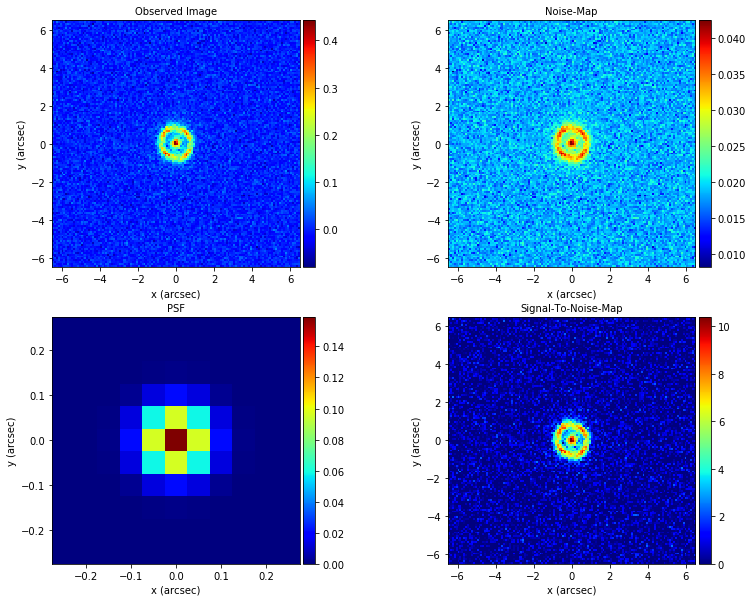

In [4]:
# Simulate the image and set it up.
image = simulate()
imaging_plotters.plot_image_subplot(image=image)

In [5]:
### Approach 1 -  Prior Tuning ###

# The first approach we're going to take is we're going to give our non-linear search a helping hand. Lets think about
# our priors - what they're doing is telling the non-linear search where to look in parameter space. If we tell it to
# look in the right place (that is, *tune* our priors), it'll probaly find the best-fit lens model.

# We've already seen that we can fully customize priors in AutoLens, so lets do it. I've set up a custom phase
# below, and specified a new set of priors that'll give the non-linear search a much better chance at inferring the
# correct model. I've also let you know what we're changing the priors from (as are specified by the
# 'config/priors/default' config files.)

class CustomPriorPhase(ph.LensSourcePlanePhase):

    def pass_priors(self, previous_results):

        # We've imported the 'model_mapper' module as 'mm' this time, to make the code more readable. We've also 
        # called our lens galaxy 'lens' this time, for shorter more readable code.

        # By default, the prior on the x and y coordinates of a light / mass profile is a GaussianPrior with mean
        # 0.0" and sigma "1.0. However, visual inspection of our strong lens image tells us that its clearly around
        # x = 0.0" and y = 0.0", so lets reduce where non-linear search looks for these parameters.

        self.lens_galaxies.lens.light.centre_0 = mm.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
        self.lens_galaxies.lens.light.centre_1 = mm.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
        self.lens_galaxies.lens.mass.centre_0 = mm.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
        self.lens_galaxies.lens.mass.centre_1 = mm.UniformPrior(lower_limit=-0.05, upper_limit=0.05)

        # By default, the axis-ratio (ellipticity) of our lens galaxy's light pofile is a UniformPrior between 0.2 and
        # 1.0. However, by looking at the image it looks fairly circular, so lets use a GaussianPrior nearer 1.0.
        self.lens_galaxies.lens.light.axis_ratio = mm.GaussianPrior(mean=0.8, sigma=0.15)

        # We'll also assume that the light profile's axis_ratio informs us of the mass-profile's axis_ratio, but
        # because this may not strictly be true (because of dark matter) we'll use a wider prior.
        self.lens_galaxies.lens.mass.axis_ratio = mm.GaussianPrior(mean=0.8, sigma=0.25)

        # By default, the orientation of the galaxy's light profile, phi, uses a UniformPrior between 0.0 and
        # 180.0 degrees. However, if you look really close at the image (and maybe adjust the color-map of the plot),
        # you'll be able to notice that it is elliptical and that it is oriented around 45.0 degrees counter-clockwise
        # from the x-axis. Lets update our prior
        self.lens_galaxies.lens.light.phi = mm.GaussianPrior(mean=45.0, sigma=15.0)

        # Again, lets kind of assume that light's orientation traces that of mass.
        self.lens_galaxies.lens.mass.phi = mm.GaussianPrior(mean=45.0, sigma=30.0)

        # The effective radius of a light profile is its 'half-light' radius, the radius at which 50% of its
        # total luminosity is internal to the circle or ellipse defined within that radius. AutoLens assumes a
        # UniformPrior on this quantity between 0.0" and 4.0", but inspection of the image (again, using a colormap
        # scaling) shows the lens's light doesn't extend anywhere near 4.0", so lets reduce it.
        self.lens_galaxies.lens.light.effective_radius = mm.GaussianPrior(mean=0.5, sigma=0.8)

        # Typically, we have some knowledge of what morphology our lens galaxy is. Infact, most strong lenses are
        # massive ellipticals, and anyone who studies galaxy morphology will tell you these galaxies have a Sersic index
        # near 4. So lets change our Sersic index from a UniformPrior between 0.8 and 8.0 to reflect this
        self.lens_galaxies.lens.light.sersic_index = mm.GaussianPrior(mean=4.0, sigma=1.0)

        # Finally, the 'ring' that the lensed source forms clearly has a radius of about 0.8". This is its Einstein
        # radius, so lets change the prior from a UniformPrior between 0.0" and 4.0".
        self.lens_galaxies.lens.mass.einstein_radius = mm.GaussianPrior(mean=0.8, sigma=0.2)

        # In this exercise, I'm not going to change any priors on the source galaxy. Whilst lens modeling experts can
        # look at a strong lens and often tell you roughly where the source-galaxy is be located (in the source-plane),
        # it is something of art form. Furthermore, the source's morphology can be pretty complex and it can become
        # its very diffcult to come up with a good source prior when this is the case.

In [6]:
# We can now create this custom phase and run it. Our non-linear search will start in a much higher likelihood region
# of parameter space.
custom_prior_phase = CustomPriorPhase(lens_galaxies=dict(lens=gm.GalaxyModel(light=lp.EllipticalSersic,
                                                                                     mass=mp.EllipticalIsothermal)),
                                      source_galaxies=dict(source=gm.GalaxyModel(light=lp.EllipticalExponential)),
                                      optimizer_class=nl.MultiNest,
                                      phase_name='4_custom_priors')
custom_prior_result = custom_prior_phase.run(image=image)

DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (-0.022009781502504336, 0.049074389928755666)
axis_ratio: 0.6819549306534282
phi: 45.801349026921415
intensity: 0.05578100401135363
effective_radius: 0.3167389163423969
sersic_index: 3.526533624265755
Mass Profiles:
EllipticalIsothermal
centre: (0.00476455070236069, -0.0339681513062684)
axis_ratio: 0.7118068268744498
phi: 34.141650277555975
einstein_radius: 0.757240606683092
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (-0.013068560405378826, -0.0004837361594883297)
axis_ratio: 0.5180089779919843
phi: 76.11736154486074
intensity: 0.10119604341345344
effective_radius: 0.17351064967493443
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.020456358094075422, -0.0015333468384519308)
axis_ratio: 0.807888513996971
phi: 47.548282899567155
intensity: 0.2346568368218534
effective_radius: 0.20693321291489103
sersic_index: 3.5450129636196084
Mass Profiles:
EllipticalIsothermal
centre: (0.023119013329704716, -0.027890121348060303)
axis_ratio: 0.8868356877125769
phi: 22.72491649273154
einstein_radius: 0.7860443716161112
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (0.033441088254670355, -0.01852556162155348)
axis_ratio: 0.8609288667527075
phi: 80.02431964707651
intensity: 0.0738591640407331
effective_radius: 0.20032964276087795
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (-0.013328080762232845, -0.033085261901377803)
axis_ratio: 0.8697022464138796
phi: 41.59156701820521
intensity: 0.27729417056653693
effective_radius: 0.14372886165312837
sersic_index: 2.8474062139878624
Mass Profiles:
EllipticalIsothermal
centre: (0.014979599161906956, -0.006905736568941355)
axis_ratio: 0.8125228214065894
phi: 40.50013161895981
einstein_radius: 0.8084596284910353
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (0.006000256137473004, -0.009318406527542109)
axis_ratio: 0.8283678150999483
phi: 82.90201190814965
intensity: 0.07013398201134638
effective_radius: 0.22615199537753983
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.03251690270435227, -0.0371787953813782)
axis_ratio: 0.8830422287302264
phi: 51.62408272933089
intensity: 0.12524061087375365
effective_radius: 0.21920811859238437
sersic_index: 4.750278937702752
Mass Profiles:
EllipticalIsothermal
centre: (-0.031064398314582554, -0.014368825579215497)
axis_ratio: 0.7589496563952749
phi: 40.625260028943515
einstein_radius: 0.8044975544261834
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (0.01032000084893412, -0.007589431789704696)
axis_ratio: 0.7064270171490274
phi: 61.06597945188712
intensity: 0.10302360885182785
effective_radius: 0.14107310487209146
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (-0.010639854433373397, 0.002786272310973524)
axis_ratio: 0.6499467566593291
phi: 66.56490530673261
intensity: 0.11535964700239887
effective_radius: 0.23725402063550666
sersic_index: 4.407232977700249
Mass Profiles:
EllipticalIsothermal
centre: (-0.03322578341281095, 0.001505855743109949)
axis_ratio: 0.9583528542732513
phi: 52.48416524805375
einstein_radius: 0.769032086502321
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (-0.031133916547985314, -0.007646630479310556)
axis_ratio: 0.6515914645276619
phi: 75.91071410814594
intensity: 0.08517157374230305
effective_radius: 0.19475845849110973
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (-0.00028196039352338526, -0.0022533022620141105)
axis_ratio: 0.8392415163371996
phi: 61.83839947950424
intensity: 0.22898174534424748
effective_radius: 0.13300371149603368
sersic_index: 6.2807231114990785
Mass Profiles:
EllipticalIsothermal
centre: (0.014707367842576174, -0.0264676939890192)
axis_ratio: 0.9621919272287079
phi: 25.647931114018608
einstein_radius: 0.782002222528325
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (-0.044683002084750706, -0.02824911450133307)
axis_ratio: 0.8616637075653537
phi: 114.37882364114388
intensity: 0.0836066014173161
effective_radius: 0.19866076987347664
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (-0.008271273228138296, -0.005383678559444174)
axis_ratio: 0.8518660660419218
phi: 47.4439528107491
intensity: 0.23922571501947948
effective_radius: 0.20823357496095485
sersic_index: 4.633649776917615
Mass Profiles:
EllipticalIsothermal
centre: (0.010750508445412046, 0.021919357649729923)
axis_ratio: 0.8317594635041744
phi: 54.56815440900629
einstein_radius: 0.7664756604752826
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (0.0249217537896291, 0.028142894598650953)
axis_ratio: 0.5434980710177468
phi: 91.60294736858336
intensity: 0.10469609019643833
effective_radius: 0.16983156411143469
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.005117522628219927, -0.025250205931079128)
axis_ratio: 0.7238301777982192
phi: 14.416633613907056
intensity: 0.08251849561033872
effective_radius: 0.22647201866041355
sersic_index: 3.9973963056254704
Mass Profiles:
EllipticalIsothermal
centre: (-0.02496663634417709, 0.00014589864032381328)
axis_ratio: 0.8613139032214044
phi: 40.702163113288115
einstein_radius: 0.7654987981784525
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (-0.011297924035202965, -0.017885369069870434)
axis_ratio: 0.37652641223720057
phi: 82.40114164064771
intensity: 0.0875126376269098
effective_radius: 0.1938302273875736
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.024072513281388305, -0.008008256559719963)
axis_ratio: 0.694139442438392
phi: 36.10591355256402
intensity: 0.23559441019563532
effective_radius: 0.22952411812611617
sersic_index: 5.621010192119062
Mass Profiles:
EllipticalIsothermal
centre: (0.02408960078628311, 0.04658522986460027)
axis_ratio: 0.7815730179874832
phi: 31.112057569088368
einstein_radius: 0.7923171584235582
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (1.5740048717361578e-05, 0.019860792058399364)
axis_ratio: 0.6488574954319701
phi: 103.61104353572563
intensity: 0.1126066262592057
effective_radius: 0.1777278985787031
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.038310188425060426, 0.0007858476620889801)
axis_ratio: 0.775152625165757
phi: 50.53142203243554
intensity: 0.08346732085818168
effective_radius: 0.28160339378142163
sersic_index: 4.351622231527624
Mass Profiles:
EllipticalIsothermal
centre: (-0.040621163472350424, -0.006837752493268998)
axis_ratio: 0.9322380761094862
phi: 52.16884096653055
einstein_radius: 0.7903094509194191
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (-0.015451702814458438, -0.015553050562602118)
axis_ratio: 0.5882327696167802
phi: 102.10954139707461
intensity: 0.07861426168979185
effective_radius: 0.20521688610010155
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.024043517799743078, 0.0068805924344818165)
axis_ratio: 0.5695657531943351
phi: 33.96200225330196
intensity: 0.1561773973969401
effective_radius: 0.18585531586517196
sersic_index: 2.6420219784972447
Mass Profiles:
EllipticalIsothermal
centre: (-0.03479387726419864, 0.004290928998856081)
axis_ratio: 0.773251849673139
phi: 54.633218374284844
einstein_radius: 0.803176080045968
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (-0.02131306585749372, 0.013485857919097637)
axis_ratio: 0.7278753032908276
phi: 99.06462497936285
intensity: 0.12372053168704142
effective_radius: 0.15295126076361834
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.015034713579224215, -0.014699682791278375)
axis_ratio: 0.965931340032599
phi: 48.32444444879506
intensity: 0.330682210471657
effective_radius: -0.02146974600437379
sersic_index: 3.245035301348343
Mass Profiles:
EllipticalIsothermal
centre: (-0.00871777413757218, -0.03073913343492432)
axis_ratio: 0.7482745627595268
phi: 35.4111741364865
einstein_radius: 0.7933459877789553
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (-0.017921541856687238, -0.010684241181375597)
axis_ratio: 0.7767782375986523
phi: 74.82994900799022
intensity: 0.09014706874313842
effective_radius: 0.20189149329301997
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.0236620713621353, -0.040032602365702996)
axis_ratio: 1.0626326350669004
phi: 46.86027471867828
intensity: 0.39161402975518017
effective_radius: 0.03732687688222158
sersic_index: 4.1331228660973585
Mass Profiles:
EllipticalIsothermal
centre: (0.0073407291052135296, -0.013373074394359578)
axis_ratio: 0.7252572719719472
phi: 45.80392989836237
einstein_radius: 0.8002134953420531
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (0.016477144338904612, -0.015393411557423586)
axis_ratio: 0.6642605907714658
phi: 89.98135014451024
intensity: 0.1058523791356337
effective_radius: 0.1864899617920961
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.013627439545863304, -0.0010388318631919732)
axis_ratio: 0.684514940428258
phi: 44.50640368770441
intensity: 0.03966764413544247
effective_radius: 0.28084711376441684
sersic_index: 4.4820850008003905
Mass Profiles:
EllipticalIsothermal
centre: (-0.010488595907647204, 0.016702193012562247)
axis_ratio: 0.736313330022679
phi: 41.47568507707513
einstein_radius: 0.7992140193177082
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (-0.024191018594445272, -0.018960348568300322)
axis_ratio: 0.5392277604521305
phi: 70.75397038900111
intensity: 0.09575909201084433
effective_radius: 0.20825308212033122
sersic_index: 1.0]




DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.026773011788606624, 0.019137910914247908)
axis_ratio: 0.9262060414560052
phi: 75.68162564601407
intensity: 0.2110094538088787
effective_radius: 0.22945450621906238
sersic_index: 3.0935315453702135
Mass Profiles:
EllipticalIsothermal
centre: (0.02199471559632793, 0.03949554782713807)
axis_ratio: 0.762878965601306
phi: 50.756692278245254
einstein_radius: 0.7926731347017019
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (0.008153958907491732, 0.014285506864816822)
axis_ratio: 0.6618311960806065
phi: 101.77542894181933
intensity: 0.13238733969336397
effective_radius: 0.14681093627597247
sersic_index: 1.0]




In [ ]:
# Bam! We get a good model. The right model. A glorious model! We gave our non-linear search a helping hand, and it
# repaid us in spades!

# Check out the PDF in the 'output/howstolens/4_custom_priors/optimizer/chains/pdfs' folder - what degeneracies do you
# notice between parameters?
lensing_fitting_plotters.plot_fitting_subplot(fit=custom_prior_result.fit)

In [ ]:
# Okay, so we've learnt that by tuning our priors to the lens we're fitting, we can increase our chance of inferring a
# good lens model. Before moving onto the next approach, lets think about the advantages and disadvantages of prior
# tuning:

# Advantage - We found the maximum likelihood solution in parameter space.
# Advantage - The phase took less time to run, because the non-linear search explored less of parameter space.
# Disadvantage - If we specified one prior incorrectly, the non-linear search would have began and therefore ended at
#                an incorrect solution.
# Disadvantage - Our phase was tailored to this specific strong lens. If we want to fit a large sample of lenses, we'd
#                have to write a custom phase for every single one - this would take up a lot of our time!

In [ ]:
### Approach 2 -  Reducing Complexity ###

# Our non-linear searched failed because we made the lens model more realistic and therefore more complex. Maybe we
# can make it less complex, whilst still keeping it fairly realistic? Maybe there are some assumptions we can make
# to reduce the number of lens model parameters and therefore dimensionality of non-linear parameter space?

# Well, we're scientists, so we can *always* make assumptions. Below, I'm going to create a phase that assumes that
# light-traces-mass. That is, that our light-profile's centre, axis_ratio and orientation are perfectly
# aligned with its mass. This may, or may not, be a reasonable assumption, but it'll remove 4 parameters from the lens
# model (the mass-profiles x, y, axis_ratio and phi), so its worth trying!

class LightTracesMassPhase(ph.LensSourcePlanePhase):

    def pass_priors(self, previous_results):

        # In the pass priors function, we can 'pair' any two parameters by setting them equal to one another. This
        # removes the parameter on the left-hand side of the pairing from the lens model, such that is always assumes
        # the same value as the parameter on the right-hand side.
        self.lens_galaxies.lens.mass_centre_0 = self.lens_galaxies.lens.light.centre_0

        # Now, the mass-profile's x coordinate will only use the x coordinate of the light profile. Lets do this with
        # the remaining geometric parameters of the light and mass profiles
        self.lens_galaxies.lens.mass_centre_1 = self.lens_galaxies.lens.light.centre_1
        self.lens_galaxies.lens.mass_axis_ratio = self.lens_galaxies.lens.light.axis_ratio
        self.lens_galaxies.lens.mass_phi = self.lens_galaxies.lens.light.phi

In [1]:
# Again, we create this phase and run it. The non-linear search has a less complex parameter space to seach, and thus
light_traces_mass_phase = LightTracesMassPhase(lens_galaxies=dict(lens=gm.GalaxyModel(light=lp.EllipticalSersic,
                                                                                       mass=mp.EllipticalIsothermal)),
                                      source_galaxies=dict(source=gm.GalaxyModel(light=lp.EllipticalExponential)),
                                      optimizer_class=nl.MultiNest,
                                               phase_name='4_light_traces_mass')

light_traces_mass_phase_result = light_traces_mass_phase.run(image=image)
lensing_fitting_plotters.plot_fitting_subplot(fit=light_traces_mass_phase_result.fit)

NameError: name 'LightTracesMassPhase' is not defined

In [ ]:
# The results look pretty good. Our source galaxy fits the data pretty well, and we've clearly inferred a model that
# looks similar to the one above. However, inspection of the residuals shows that the fit wasn't quite as good as the
# custom-phase above.

# It turns out that when I simulated this image, light didn't perfectly trace mass. The light-profile's axis-ratio was
# 0.9, whereas the mass-profiles was 0.8. The quality of the fit has suffered as a result, and the likelihood we've
# inferred is lower.
#
# Herein lies the pitfalls of making assumptions in science - they may make your model less realistic and your results
# worse! Nevertheless, our lens model is clearly much better than it was in the previous tutorial, so making
# assumptions isn't a bad idea if you're struggling to fit the data t all.

# Again, lets consider the advantages and disadvantages of this approach:

# Advantage - By reducing parameter space's complexity, we inferred the global maximum likelihood.
# Advantage - The phase is not specific to one lens - we could run it on many strong lens images.
# Disadvantage - Our model was less realistic, and our fit suffered as a result.

In [ ]:
### Approach 3 -  Look Harder ###

# In approaches 1 and 2, we extended our non-linear search an olive branch and generously helped it find the highest
# likelihood regions of parameter space. In approach 3 ,we're going to be stern with our non-linear search, and tell it
# 'look harder'.

# Basically, every non-linear search algorithm has a set of parameters that govern how thoroughly it searches parameter
# space. The more thoroughly it looks, the more like it is that it'll find the global maximum lens model. However,
# the search will also take longer - and we don't want it to take too long to get some results.

# Lets setup a phase, and overwrite some of the non-linear search's parameters from the defaults it assumes in the
# 'config/non_linear.ini' config file:

custom_non_linear_phase = ph.LensSourcePlanePhase(lens_galaxies=dict(lens=gm.GalaxyModel(light=lp.EllipticalSersic,
                                                                                mass=mp.EllipticalIsothermal)),
                                      source_galaxies=dict(source=gm.GalaxyModel(light=lp.EllipticalExponential)),
                                      optimizer_class=nl.MultiNest,
                                                  phase_name='4_custom_non_linear')

In [ ]:
# The 'optimizer' below is MultiNest, the non-linear search we're using.

# When MultiNest searches non-linear parameter space, it places down a set of 'live-points', each of which corresponds
# to a particular lens model (set of parameters) and has an associted likelihood. If it guesses a new lens model with a
# higher likelihood than any of the currently active live points, this new lens model will become an active point. As a
# result, the active point with the lowest likelihood is discarded.

# The more live points MultiNest uses, the more thoroughly it will sample parameter space. Lets increase the number of
# points from the default value (50) to 100.
custom_non_linear_phase.optimizer.n_live_points = 100

In [ ]:
# When MultiNest thinks its found a 'peak' likelihood in parameter space, it begins to converge around this peak. It
# does this by guessing lens models with similar parameters. However, this peak might not be the global maximum,
# and if MultiNest converges too quickly around a peak it won't realise this before its too late.
#
# The sampling efficiency therefore describes how quickly MultiNest converges around a peak. It assumes values between
# 0.0 and 1.0, where 1.0 corresponds to the fastest convergance but highest risk of not locating the global maximum.
# Lets reduce the sampling efficiency from 0.8 to 0.5.
custom_non_linear_phase.optimizer.sampling_efficiency = 0.5

In [ ]:
# These are the two most important MultiNest parameters controlling how it navigates parameter space, so lets run this
# phase and see if our more detailed inspection of parameter space finds the correct lens model.
custom_non_linear_result = custom_non_linear_phase.run(image=image)

In [ ]:
# Indeed, it does. Thus, we can always brute-force our way to a good lens model, if all else fails.
lensing_fitting_plotters.plot_fitting_subplot(fit=custom_non_linear_result.fit)


In [ ]:
# Finally, lets list the advantages and disadvantages of this approach:

# Advantage - Its easy to setup, we just increase n_live_points or decrease sampling_efficiency.
# Advantage - It generalizes to any strong lens.
# Advantage - We didn't have to make our model less realistic.
# Disadvantage - Its expensive. Very expensive. The run-time of this phase was over 6 hours. For more complex models
#                we could be talking days or weeks (or, dare I say it, months).

In [ ]:
# So, there we have it, we can now fit strong lenses PyAutoLens. And if it fails, we know how to get it to work. I hope
# you're feeling pretty smug. You might even be thinking 'why should I bother with the rest of these tutorials, if I
# can fit strong a lens already'.

# Well, my friend,  I want you to think about the last disadvantage listed above. If modeling a single lens could
# really take as long as a month, are you really willing to spend your valuable time waiting for this? I'm not, which
# is why I developed AutoLens, and in the next tutorial we'll see how we can get the best of both worlds - realistic,
# complex lens model that take mere hours to infer!

# Before doing that though, I want you to go over the advantages and disadvantages listed above again, and think
# whether we could combine these different approaches to get the best of all worlds.